<a href="https://colab.research.google.com/github/maziarkanani/Grammatical-Structure-and-Grammatical-Variations-in-Non-Metric-Iranian-Classical-Music/blob/main/ssl_ismir_JEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Supervised Learning for Music : Joint Embedding Approaches



Welcome to this comprehensive tutorial on self-supervised learning for music! In this notebook, we'll explore how to build and train a contrastive learning model for learning meaningful representations from music audio data.

### What You'll Learn

By the end of this tutorial, you will understand:

1. **Data Preprocessing**: How to load and preprocess music audio data
2. **Augmentation Strategies**: Creating multiple views of the same audio for contrastive learning
3. **Model Architecture**: Building a VGGish backbone with projection head
4. **Contrastive Learning**: Implementing NTXent loss for representation learning
5. **Training Pipeline**: Setting up PyTorch Lightning for scalable training
6. **Visualization**: Monitoring training progress and embedding quality

### Prerequisites

- Basic knowledge of PyTorch and deep learning
- Familiarity with audio processing concepts
- Understanding of self-supervised learning principles

### Dataset

We'll be using the **Giantsteps** dataset, which contains electronic dance music tracks. This dataset is particularly suitable for contrastive learning as it contains diverse musical content that can benefit from learned representations.

---

## Table of Contents

1. [Setup and Imports](#setup)
2. [Data Loading and Exploration](#data-loading)
3. [Data Preprocessing and Augmentation](#preprocessing)
4. [Model Architecture](#model-architecture)
5. [Training Setup](#training-setup)
6. [Training Execution](#training-execution)
7. [Results and Visualization](#results)
8. [Next Steps](#next-steps)

> 💡 **Note**  
> Dependencies might break here because of reinstalling numpy. Just restart the session (not runtime) and you'll be golden



In [ ]:
 # !rm -r SSLISMIR/

!git clone https://github.com/Pliploop/SSLISMIR.git
!git pull
!ls
# set working directory
%cd SSLISMIR


!pip install -r requirements.txt
!pip install mirdata pandas lightning ema_pytorch
!python scripts/download_giantsteps.py

Cloning into 'SSLISMIR'...
remote: Enumerating objects: 684, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 684 (delta 0), reused 2 (delta 0), pack-reused 681 (from 1)
Receiving objects: 100% (684/684), 68.80 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (350/350), done.
fatal: not a git repository (or any of the parent directories): .git
sample_data  SSLISMIR
/content/SSLISMIR
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 144.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

## 1. Setup and Imports {#setup}

Let's start by importing the necessary libraries and setting up our environment. We'll be using PyTorch for deep learning, PyTorch Lightning for training, and various audio processing libraries.


In [ ]:
!pip install omegaconf


In [ ]:
# Import necessary libraries
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from src.data.dataset import Giantsteps
from src.data.dataset import MultiView, MelSpectrogram, TimeFrequencyMask, Truncate
from src.models.backbones import VGGish, MLP
from src.models.training_wrappers import ContrastiveLearning
from src.utils.losses import NTXent
from src.data.collate import multiview_collate
from src.utils.viz import show_audio_and_spectrogram
from src.callbacks.viz2d import Embedding2DVisualizationCallback

# PyTorch Lightning imports
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {L.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

✅ All imports successful!
PyTorch version: 2.8.0+cu126
PyTorch Lightning version: 2.5.5
CUDA available: True
CUDA device: Tesla T4


## 2. Data Loading and Exploration {#data-loading}

Now let's load our dataset and explore the music data. We'll start with a simple dataset load to understand the structure and listen to some samples.


In [ ]:
# Load the Giantsteps dataset
print("Loading Giantsteps dataset...")
gs = Giantsteps(labels_=True) # Set labels_ to True to load labels
print(f"Dataset loaded! Total samples: {len(gs)}")

# Get a sample from the dataset
sample = gs[0]
print(f"Sample keys: {sample.keys()}")
print(f"Audio shape: {sample['audio'].shape}")
print(f"Audio duration: {sample['audio'].shape[0] / 16000:.2f} seconds")
print(f"Label: {sample['label_']}") # Print the label

# Listen to the original audio
print("\n🎵 Original Audio Sample:")
Audio(sample['audio'], rate=16000)

Loading Giantsteps dataset...
Dataset loaded! Total samples: 570
Sample keys: dict_keys(['audio', 'label_', 'name', 'file_path', 'view_1', 'view_2'])
Audio shape: torch.Size([1920941])
Audio duration: 120.06 seconds
Label: 17

🎵 Original Audio Sample:


## 3. Data Preprocessing and Augmentation {#preprocessing}

For contrastive learning, we need to create multiple views of the same audio sample. This is crucial because contrastive learning works by learning representations that are similar for different views of the same data and different for views of different data.

### Key Concepts in Contrastive Learning Data Augmentation

1. **Multi-View Generation**: Create different "views" of the same audio
2. **Mel Spectrogram Conversion**: Convert audio to frequency domain representation
3. **Data Augmentation**: Apply transformations to increase diversity

Let's set up our data processing pipeline:


In [ ]:
47999/16000

2.9999375

In [ ]:
# Define our data processing pipeline
processors = [
    # 1. MultiView: Create two random views of the same audio
    MultiView(view_samples=47999, strategy="random_view", keys=["audio"]),

]

# Create augmented dataset with our processors
print("\nCreating augmented dataset...")
gs_aug = Giantsteps(processors=processors, labels_=False)
print(f"Augmented dataset created! Total samples: {len(gs_aug)}")

# Get a sample from the augmented dataset
sample_aug = gs_aug[0]
print(f"Augmented sample keys: {sample_aug.keys()}")
print(f"View 1 shape: {sample_aug['view_1'].shape}")
print(f"View 2 shape: {sample_aug['view_2'].shape}")


Creating augmented dataset...
Augmented dataset created! Total samples: 570
Augmented sample keys: dict_keys(['audio', 'file_path', 'view_1', 'view_2'])
View 1 shape: torch.Size([47999])
View 2 shape: torch.Size([47999])


### Visualizing the Augmented Data

Now let's visualize our two views to understand how the augmentation works. We'll create mel spectrograms and display them side by side.


Creating mel spectrogram visualizations...


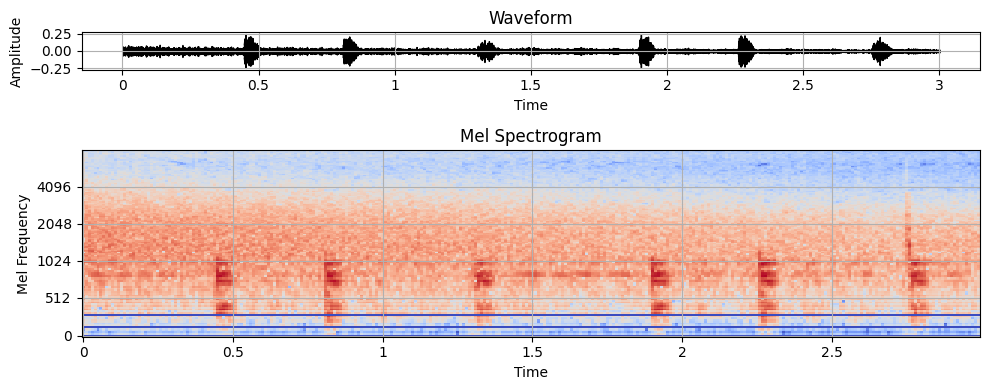

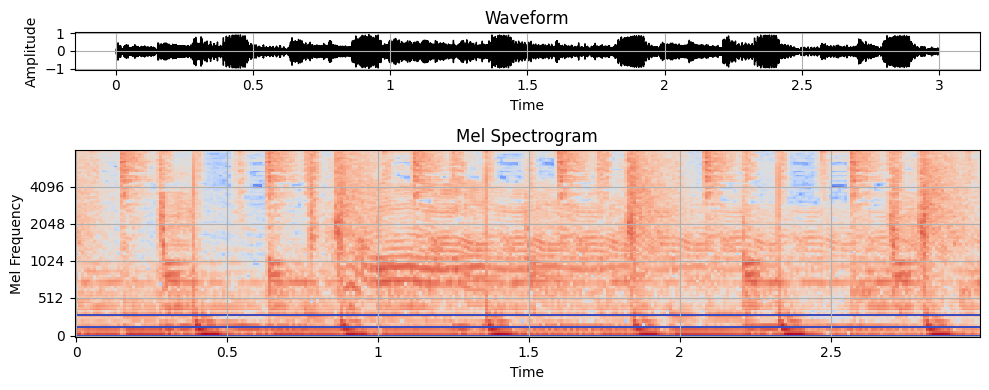

In [ ]:
# Visualize the two views using our custom visualization function
print("Creating mel spectrogram visualizations...")
view1_fig = show_audio_and_spectrogram(sample_aug['view_1'], 16000, f_min=50, f_max=8000)
view2_fig = show_audio_and_spectrogram(sample_aug['view_2'], 16000, f_min=50, f_max=8000)


### Creating Data Loaders

Now let's create data loaders for training. We'll use a custom collate function that handles the multiview data structure properly.


Batch keys: dict_keys(['views', 'label_', 'audio', 'name', 'file_path', 'target_sims'])
Views shape: torch.Size([16, 128, 300])
Expected shape: [batch_size * 2, channels, height, width] = [64, 128, 300]
torch.Size([128, 300])
torch.Size([128, 300])


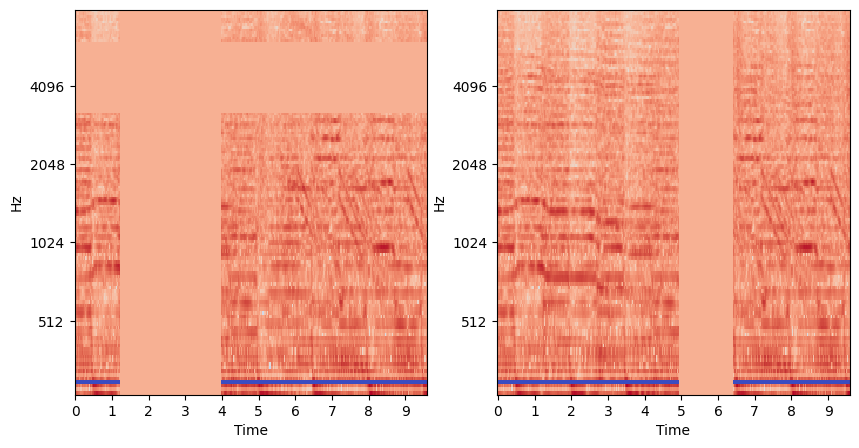

In [ ]:
# Create data loader with custom collate function

dataset = Giantsteps(
    processors = [
    MultiView(view_samples=47999, strategy="same_view", keys=["audio"]),
    Truncate(keys=["audio"], n_samples=48000),

    MelSpectrogram(
        sample_rate=16000,
        n_fft=512,
        hop_length=160,
        n_mels=128,
        f_min=50,
        f_max=8000,
        win_length=None,
        power=2.0,
        keys=["view_1", "view_2", 'audio']
    ),
    TimeFrequencyMask(keys=["view_1", "view_2", 'audio'])
    ],
    labels_=True
)

batch_size = 8
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=multiview_collate,
    num_workers=4
)


# Test the data loader with a single batch
batch = next(iter(dataloader))
print(f"Batch keys: {batch.keys()}")
print(f"Views shape: {batch['views'].shape}")
print(f"Expected shape: [batch_size * 2, channels, height, width] = [64, 128, 300]")

view_1 = batch['views'][0]
view_2 = batch['views'][batch_size]

print(view_1.shape)
print(view_2.shape)

fig,ax = plt.subplots(1,2,figsize=(10,5))
librosa.display.specshow(view_1.numpy(), ax=ax[0], sr=16000, x_axis='time', y_axis='mel', fmax=8000, fmin=50)
librosa.display.specshow(view_2.numpy(), ax=ax[1], sr=16000, x_axis='time', y_axis='mel', fmax=8000, fmin=50)



## 4. Model Architecture

Now let's build our contrastive learning model. We'll use a two-part architecture:

1. **Backbone**: VGGish-style CNN for feature extraction
2. **Projection Head**: MLP for contrastive learning

### Understanding the Architecture

The VGGish backbone processes mel spectrograms and extracts high-level features, while the projection head maps these features to a lower-dimensional space suitable for contrastive learning.


In [ ]:
# Create the VGGish backbone
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print("Creating VGGish backbone...")
vggish = VGGish(
    proj_dim=512,
    channels=[128, 128, 256, 512]
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"VGGish parameters: {count_parameters(vggish):,}")

# Test with real batch
print("\nTesting backbone with real batch...")
with torch.no_grad():
    real_output = vggish(batch['views'].to(device))
    print(f"Real batch output shape: {real_output['z'].shape}")


Using device: cuda
Creating VGGish backbone...
VGGish parameters: 5,300,864

Testing backbone with real batch...
Real batch output shape: torch.Size([16, 512])


### Creating the Projection Head

The projection head is crucial for contrastive learning. It maps the high-dimensional backbone features to a lower-dimensional space where we can compute similarities effectively.


In [ ]:
# Create the projection head
print("Creating MLP projection head...")
projection_head = MLP(
    in_features=512,      # Input from VGGish backbone
    out_features=64,     # Output dimension for contrastive learning
    hidden_features=[512],  # Hidden layers
    activation="relu",
    use_batch_norm=True,
    dropout=0.0,
    bias=True
).to(device)

print(f"Projection head parameters: {count_parameters(projection_head):,}")

# Test the projection head
print("\nTesting projection head...")
with torch.no_grad():
    # Use the backbone output from our real batch
    backbone_features = vggish(batch['views'].to(device))['z']
    projected_features = projection_head(backbone_features)

    print(f"Backbone features shape: {backbone_features.shape}")
    print(f"Projected features shape: {projected_features.shape}")

print(f"\nTotal model parameters: {count_parameters(vggish) + count_parameters(projection_head):,}")

Creating MLP projection head...
Projection head parameters: 296,512

Testing projection head...
Backbone features shape: torch.Size([16, 512])
Projected features shape: torch.Size([16, 64])

Total model parameters: 5,597,376


## 5. Training Setup {#training-setup}

Now let's set up the contrastive learning training pipeline. We'll use:

1. **NTXent Loss**: Normalized Temperature-scaled Cross Entropy loss
2. **Adam Optimizer**: For parameter updates
3. **PyTorch Lightning**: For scalable training

### Understanding Contrastive Learning

Contrastive learning works by:
- **Positive pairs**: Different views of the same sample should have similar representations
- **Negative pairs**: Different samples should have different representations
- **Loss function**: Minimizes distance between positive pairs, maximizes distance between negative pairs


In [ ]:
# Configure loss function
loss_params = {
    "_name_": "src.utils.losses.NTXent",
    "_kwargs_": {
        "temperature": 0.07,
        "contrast_mode": "all",
        "base_temperature": 0.07
    }
}

# Configure optimizer
opt_params = {
    "_name_": "torch.optim.Adam",
    "_kwargs_": {"lr": 0.0001}
}



# Create the ContrastiveLearning model
print("\nCreating ContrastiveLearning model...")
CL = ContrastiveLearning(
    backbone=vggish,
    projection_head=projection_head,
    loss_params=loss_params,
    opt_params=opt_params,
    sched_params=None,
    ema_params=None
)

print("✅ ContrastiveLearning model created successfully!")
# Test a single training step
print("\nTesting training step...")
batch = {
    k: v.to(device) for k, v in batch.items() if hasattr(v, "to")
}
test_loss = CL.training_step(batch, 0)
print(f"Training step completed! Loss: {test_loss:.4f}")



Creating ContrastiveLearning model...
instantiating src.utils.losses.NTXent
✅ ContrastiveLearning model created successfully!

Testing training step...
Training step completed! Loss: 4.4327


In [ ]:
print("Iterating through the first 2 batches to show data structure...")

# Iterate through the first 2 batches
for i, batch in enumerate(dataloader):
    if i >= 2:
        break

    print(f"\n--- Batch {i+1} ---")
    print(f"Batch keys: {batch.keys()}")
    print(f"Views shape: {batch['views'].shape}")
    print(f"Labels: {batch['label_']}") # Display the labels

    # Explain how views are paired
    print("\nUnderstanding View Pairing for Contrastive Loss:")
    print(f"The 'views' tensor has shape {batch['views'].shape}.")
    print(f"It contains {batch['views'].shape[0] // 2} pairs of views.")
    print("The first half of the tensor contains the first view of each sample in the batch.")
    print("The second half contains the second view of each corresponding sample.")
    print("For example, views[0] and views[batch_size] are a positive pair.")
    print("views[1] and views[batch_size + 1] are another positive pair, and so on.")
    print("Labels correspond to the original samples before view duplication.")
    print("The loss function uses the indices to identify positive pairs (views from the same original sample) and negative pairs (views from different original samples).")

    # Optionally, show shapes of individual views
    batch_size = batch['views'].shape[0] // 2
    print(f"\nShape of the first view in the batch: {batch['views'][0].shape}")
    print(f"Shape of the corresponding second view: {batch['views'][batch_size].shape}")

Iterating through the first 2 batches to show data structure...

--- Batch 1 ---
Batch keys: dict_keys(['views', 'label_', 'audio', 'name', 'file_path', 'target_sims'])
Views shape: torch.Size([16, 128, 300])
Labels: [25, 17, 1, 8, 12, 25, 25, 23, 25, 17, 1, 8, 12, 25, 25, 23]

Understanding View Pairing for Contrastive Loss:
The 'views' tensor has shape torch.Size([16, 128, 300]).
It contains 8 pairs of views.
The first half of the tensor contains the first view of each sample in the batch.
The second half contains the second view of each corresponding sample.
For example, views[0] and views[batch_size] are a positive pair.
views[1] and views[batch_size + 1] are another positive pair, and so on.
Labels correspond to the original samples before view duplication.
The loss function uses the indices to identify positive pairs (views from the same original sample) and negative pairs (views from different original samples).

Shape of the first view in the batch: torch.Size([128, 300])
Shape

In [ ]:
batch

{'views': tensor([[[  5.7258,   5.8357,   5.7665,  ...,   6.2791,   6.4157,   6.1064],
          [ -0.3750,   1.0024,   2.2553,  ...,   1.7955,   2.2648,   2.1340],
          [  3.7319,   5.1093,   6.3622,  ...,   5.9024,   6.3717,   6.2409],
          ...,
          [  0.2123,   1.1761,   1.5410,  ...,   0.7962,   1.1205,   1.5174],
          [  0.9601,   1.7506,   1.5239,  ...,   1.5867,   1.0929,   1.5234],
          [  1.3886,   0.3572,   0.3100,  ...,   1.8036,   1.9547,   1.9563]],
 
         [[  0.2330,  -2.8155,  -4.4343,  ...,   5.7125,   6.6827,   7.0209],
          [ -9.9428,  -2.8297,  -2.9010,  ...,   0.2904,   1.9167,   2.2830],
          [ -5.8361,   1.2771,   1.2059,  ...,   4.3973,   6.0236,   6.3899],
          ...,
          [-14.5530, -13.3626, -13.4135,  ...,  -3.0805,  -3.2734,  -3.3110],
          [-16.1297, -15.2385, -14.9569,  ...,  -2.2125,  -2.8203,  -2.4650],
          [-14.8779, -13.9640, -14.2711,  ...,  -3.8615,  -3.5728,  -3.7259]],
 
         [[  6.8372

## 6. Training Execution

Now let's set up and run the training! We'll use PyTorch Lightning for scalable training with:

- **Weights & Biases**: For experiment tracking and visualization
- **Rich Model Summary**: For detailed model architecture overview
- **Embedding Visualization**: For monitoring learned representations



In [ ]:
# Set up Weights & Biases logger
print("Setting up Weights & Biases logger...")
wandb_logger = WandbLogger(
    project="music-ssl-ismir",
    log_model=True
)



# Set up callbacks
print("Setting up training callbacks...")
callbacks = [
    # Rich model summary for detailed architecture overview
    # L.pytorch.callbacks.RichModelSummary(max_depth=2),

    # Embedding visualization for monitoring learned representations
    Embedding2DVisualizationCallback(
        every_n_steps=100,
        reduction_method="umap",
    )
]

# Create the trainer
print("Creating PyTorch Lightning trainer...")
trainer = L.Trainer(
    max_epochs=100,
    devices=[0],
    accelerator='gpu',
    precision='16-mixed',
    logger=wandb_logger,
    callbacks=callbacks,
    log_every_n_steps=100,
    val_check_interval=1.0,
    gradient_clip_val=1.0,
    deterministic=True
)



INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_

Setting up Weights & Biases logger...
Setting up training callbacks...
Creating PyTorch Lightning trainer...


In [ ]:
trainer.fit(CL, train_dataloaders=dataloader, val_dataloaders=dataloader)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: emiliomartinez98 (emiliomartinez98-universidad-de-la-republica) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type       | Params | Mode
------------------------------------------------------
0 | backbone        | VGGish     | 5.3 M  | eval
1 | loss            | NTXent     | 0      | eval
2 | projection_head | MLP        | 296 K  | eval
3 | model           | ModuleDict | 5.6 M  | eval
------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.390    Total estimated model params size (MB)
0         Modules in train mode
47        Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type       | Params | Mode
------------------------------------------------------
0 | backbone        | VGGish     | 5.3 M  | eval
1 | loss            | NTXent     | 0      | eval
2 | projection_head | MLP        | 296 K  | eval
3 | model      

instantiating torch.optim.Adam


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 598, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 1011, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 1055, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py", line 216, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py", line 458, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/usr/local/lib/python3.12

TypeError: object of type 'NoneType' has no len()

Extracting embeddings from test samples...
Backbone features shape: torch.Size([64, 512])
Projection head features shape: torch.Size([64, 64])
Similarity matrix shape: torch.Size([64, 64])
Average positive similarity: 0.7435
Std positive similarity: 0.0919
Average negative similarity: nan
Std negative similarity: nan


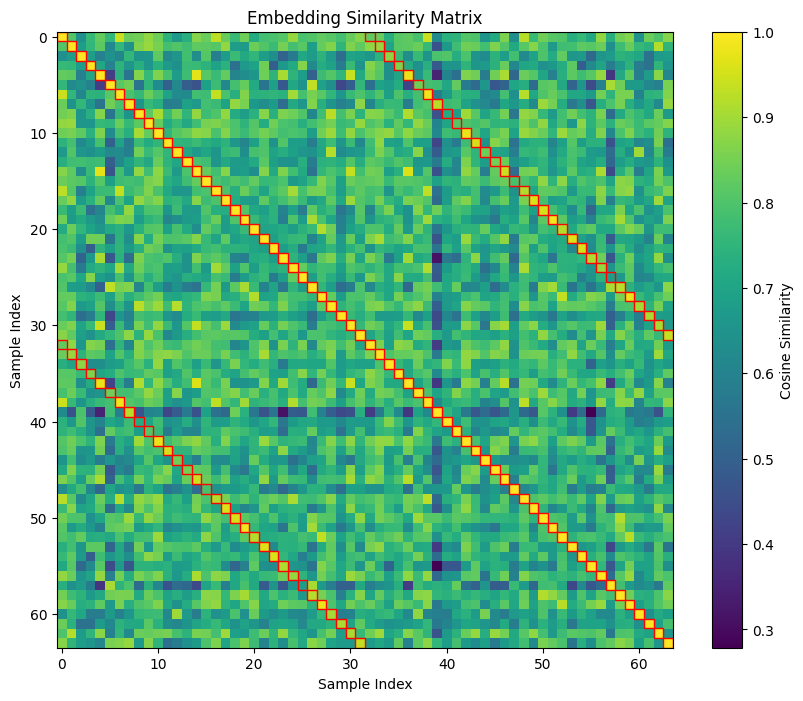

In [ ]:
import torch.nn.functional as F

# Set model to evaluation mode
CL.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CL.to(device)

default_checkpoint_path = 'music-ssl-ismir/kqrp1jio/checkpoints/epoch=359-step=6480.ckpt'
checkpoint = torch.load(default_checkpoint_path, map_location=device)
CL.load_state_dict(checkpoint['state_dict'])


dataset = Giantsteps(
    processors = [
    MultiView(view_samples=47999, strategy="random_view", keys=["audio"]),
    Truncate(keys=["audio"], n_samples=48000),

    MelSpectrogram(
        sample_rate=16000,
        n_fft=512,
        hop_length=160,
        n_mels=128,
        f_min=50,
        f_max=8000,
        win_length=None,
        power=2.0,
        keys=["view_1", "view_2", 'audio']
    ),
    ],
    labels_=True
)

batch_size = 32
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=multiview_collate,
    num_workers=4
)

# Extract embeddings from a few samples
print("Extracting embeddings from test samples...")
with torch.no_grad():
    # Get a batch of data
    test_batch = next(iter(dataloader))

    # Extract features using the backbone
    backbone_features = CL.backbone(test_batch['views'].to(device))['z']
    projection_head_features = CL.projection_head(backbone_features)
    print(f"Backbone features shape: {backbone_features.shape}")
    print(f"Projection head features shape: {projection_head_features.shape}")

    # Project to embedding space
    embeddings = projection_head_features
    embeddings = F.normalize(embeddings, p=2, dim=1)

    # Compute similarity matrix
    similarity_matrix = torch.mm(embeddings, embeddings.t())
    print(f"Similarity matrix shape: {similarity_matrix.shape}")

    batch_size = test_batch['views'].shape[0] // 2
    positive_similarities = []
    negative_similarities = []
    for i in range(batch_size):
        for j in range(batch_size):
            if i != j:
              if i+batch_size == j or i == j+batch_size:
                negative_similarities.append(similarity_matrix[i, j].item())
              else:
                positive_similarities.append(similarity_matrix[i, j].item())

    print(f"Average positive similarity: {np.mean(positive_similarities):.4f}")
    print(f"Std positive similarity: {np.std(positive_similarities):.4f}")

    print(f"Average negative similarity: {np.mean(negative_similarities):.4f}")
    print(f"Std negative similarity: {np.std(negative_similarities):.4f}")


# Visualize the similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix.cpu().numpy(), cmap='viridis')
# put red outlines around the positive pairs
for i in range(batch_size*2):
    for j in range(batch_size*2):
        if i == j+batch_size or i+batch_size == j or i == j:
            plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, color='red'))
plt.colorbar(label='Cosine Similarity')
plt.title('Embedding Similarity Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()
